# Expectation-maximization algorithm

In this assignment, we will derive and implement formulas for Gaussian Mixture Model — one of the most commonly used methods for performing soft clustering of the data. 

### Installation

We will need ```numpy```, ```scikit-learn```, ```matplotlib``` libraries for this assignment

In [429]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
from grader import Grader
%matplotlib inline

### Grading
We will create a grader instance below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to the platform only after running submitting function in the last part of this assignment. If you want to make a partial submission, you can run that cell anytime you want.

In [430]:
grader = Grader()

## Implementing EM for GMM

For debugging we will use samples from gaussian mixture model with unknown mean, variance and priors. We also added inital values of parameters for grading purposes.

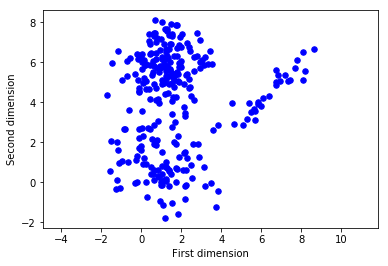

In [431]:
samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='blue', s=30)
plt.xlabel("First dimension")
plt.ylabel("Second dimension")
plt.axis('equal')
plt.show()

### Reminder

Remember, that EM algorithm is a coordinate descent optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{P(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br> 
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned. $T_i$ (cluster index for object $i$) is a binary vector with only one active bit in position corresponding to the true component. For example, if we have $C=3$ components and object $i$ lies in first component, $T_i = [1, 0, 0]$.

The joint distribution can be written as follows: $p(T, X \mid \theta) =  \prod\limits_{i=1}^N p(T_i, X_i \mid \theta) = \prod\limits_{i=1}^N \prod\limits_{c=1}^C [\pi_c \mathcal{N}(X_i \mid \mu_c, \Sigma_c)]^{T_{ic}}$.

### E-step
In this step we need to estimate the posterior distribution over the latent variables with fixed values of parameters: $q(T) = p(T|X, \theta)$. We will assume that $T_i$ (cluster index for object $i$) is a binary vector with only one '1' in position corresponding to the true component. To do so we need to compute $\gamma_{ic} = P(T_{ic} = 1 \mid X, \theta)$. Note that $\sum\limits_{c=1}^C\gamma_{ic}=1$.


<b>Important trick 1:</b> It is important to avoid numerical errors. At some point you will have to compute the formula of the following form: $\frac{e^{x_i}}{\sum_j e^{x_j}}$. When you compute exponents of large numbers, you get huge numerical errors (some numbers will simply become infinity). You can avoid this by dividing numerator and denominator by $e^{\max(x)}$: $\frac{e^{x_i-\max(x)}}{\sum_j e^{x_j - \max(x)}}$. After this transformation maximum value in the denominator will be equal to one. All other terms will contribute smaller values. This trick is called log-sum-exp. So, to compute desired formula you first subtract maximum value from each component in vector $X$ and then compute everything else as before.

<b>Important trick 2:</b> You will probably need to compute formula of the form $A^{-1}x$ at some point. You would normally inverse $A$ and then multiply it by $x$. A bit faster and more numerically accurate way to do this is to solve the equation $Ay = x$. Its solution is $y=A^{-1}x$, but the equation $Ay = x$ can be solved by Gaussian elimination procedure. You can use ```np.linalg.solve``` for this.

<b>Other usefull functions: </b> <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html">```slogdet```</a> and <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.det.html#numpy.linalg.det">```det```</a>

<b>Task 1:</b> Implement E-step for GMM using template below.

In [432]:
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T) 
    

    ### YOUR CODE HERE
    
    ### My aim is to find the gamma for each data point q(T) which is discrete and equal to p(T|X,theta)
    ### which is equal to p(X|T) * p(T)
    
    ### First generate a likelihood matrix
    likelihood = np.zeros((N,C)) # distribution p(X|T)
    
    for i in range(N):
        max_x = 0
        for j in range(C):
            eig_values = np.array(np.linalg.eigvals(sigma[j]))
            pseudo_det = np.product(eig_values[eig_values > 1/(10**12)])
            sq_root_det_sigma = np.sqrt(pseudo_det)
            #sign, logdet = np.linalg.slogdet(sigma[j])
            #sq_root_det_sigma = np.sqrt(sign * np.exp(logdet))
            denom = 2 * np.pi * sq_root_det_sigma
            diff = X[i]-mu[j]
            diff = diff.reshape(diff.shape[0],1)
            ### compute the likelihood for each data point given each cluster p(x_i|t_i)
            likelihood[i][j] = np.exp( (-1/2) * np.dot(np.dot(np.transpose(diff),np.linalg.pinv(sigma[j])),diff)) / denom
            if j == 0:
                max_x = likelihood[i][j]
            else:
                if (likelihood[i][j]>max_x):
                    max_x = likelihood[i][j]
            gamma[i][j] = likelihood[i][j]*pi[j] 
        norm_cons = np.sum(gamma[i]/max_x)
        gamma[i] = gamma[i]/max_x/norm_cons
        
    return gamma

In [433]:
E_step(X, pi0, mu0, sigma0)

array([[9.89984413e-001, 1.00155874e-002, 2.51121517e-016],
       [9.77802155e-001, 2.21978447e-002, 1.07229089e-014],
       [9.78228436e-001, 2.17715636e-002, 6.65282252e-016],
       [9.99470994e-001, 5.29005851e-004, 7.87626322e-024],
       [9.99482344e-001, 5.17656126e-004, 3.24388347e-026],
       [6.83857110e-005, 9.99931614e-001, 1.15852408e-020],
       [1.50729715e-036, 1.00000000e+000, 2.89692453e-057],
       [1.83115480e-001, 8.16884375e-001, 1.44924709e-007],
       [9.60027562e-001, 3.99724376e-002, 7.78636239e-013],
       [4.35705967e-001, 5.33717874e-001, 3.05761590e-002],
       [4.22427127e-001, 5.74733674e-001, 2.83919872e-003],
       [9.88286857e-001, 1.17131434e-002, 1.83043464e-016],
       [5.42939168e-001, 4.56729246e-001, 3.31586125e-004],
       [1.08502493e-001, 8.91497507e-001, 8.73826666e-032],
       [6.27715071e-004, 9.99372285e-001, 3.50074230e-024],
       [8.65821552e-001, 1.34178197e-001, 2.50489977e-007],
       [1.34635440e-010, 1.00000000e+000

In [434]:
gamma = E_step(X, pi0, mu0, sigma0)
grader.submit_e_step(gamma)

Current answer for task Task 1 (E-step) is: 0.533717874108129


### M-step

In M-step we need to maximize $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ with respect to $\theta$. In our model this means that we need to find optimal values of $\pi$, $\mu$, $\Sigma$. To do so, you need to compute the derivatives and 
set them to zero. You should start by deriving formulas for $\mu$ as it is the easiest part. Then move on to $\Sigma$. Here it is crucial to optimize function w.r.t. to $\Lambda = \Sigma^{-1}$ and then inverse obtained result. Finaly, to compute $\pi$, you will need <a href="https://www3.nd.edu/~jstiver/FIN360/Constrained%20Optimization.pdf">Lagrange Multipliers technique</a> to satisfy constraint $\sum\limits_{i=1}^{n}\pi_i = 1$.

<br>
<b>Important note:</b> You will need to compute derivatives of scalars with respect to matrices. To refresh this technique from previous courses, see <a href="https://en.wikipedia.org/wiki/Matrix_calculus"> wiki article</a> about it . Main formulas of matrix derivatives can be found in <a href="http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf">Chapter 2 of The Matrix Cookbook</a>. For example, there you may find that $\frac{\partial}{\partial A}\log |A| = A^{-T}$.


<b>Task 2:</b> Implement M-step for GMM using template below.

## Derivatives wrt $\mu_c$, $\Sigma_c$, $\pi$ taken from:

https://zhiyzuo.github.io/EM/#convergence

In [546]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE
    mu_ = np.zeros((C,d))
    sigma_ = np.zeros((C,d,d))
    pi_ = np.zeros((C,1))
    
    # I aim to calculate parameters maximizing the expection of log P(X,T|theta)
    # Finding the mu
    
    for j in range(C):
        denom_sum, nom_sum = 0, 0 
        for i in range(N):
            nom_sum += gamma[i][j] * X[i]
            denom_sum += gamma[i][j]
        mu_[j] = nom_sum/denom_sum 
        
    # Finding the sigma  
    for j in range(C):
        denom_sum, nom_sum = 0, 0 
        for i in range(N):
            x_m = (X[i] - mu_[j]).reshape((X[i] - mu_[j]).shape[0],1)
            nom_sum += gamma[i][j] * np.dot(x_m,np.transpose(x_m))
            denom_sum += gamma[i][j]
        sigma_[j] = nom_sum/denom_sum 
        
    # Finding the pi  
    for j in range(C):
        nom_sum = 0
        for i in range(N):
            nom_sum += gamma[i][j]
        pi_[j] = nom_sum/N 
    
    return pi_, mu_, sigma_

In [548]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step(X, gamma)
grader.submit_m_step(pi, mu, sigma)

Current answer for task Task 2 (M-step: mu) is: 2.8993918820503897
Current answer for task Task 2 (M-step: sigma) is: 5.977105216897535
Current answer for task Task 2 (M-step: pi) is: 0.5507624459218785


### Loss function

Finally, we need some function to track convergence. We will use variational lower bound $\mathcal{L}$ for this purpose. We will stop our EM iterations when $\mathcal{L}$ will saturate. Usually, you will need only about 10-20 iterations to converge. It is also useful to check that this function never decreases during training. If it does, you have a bug in your code.

<b>Task 3:</b> Implement a function that will compute $\mathcal{L}$ using template below.

$$\mathcal{L} = \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] (\log \pi_k + \log \mathcal{N}(x_n | \mu_k, \sigma_k)) - \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] \log \mathbb{E}[z_{n, k}]$$

In [804]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE
    ft, st = 0, 0
    for i in range(N):
        for j in range(C):
            w = gamma[i][j]
            x_m = (X[i] - mu[j]).reshape((X[i] - mu[j]).shape[0],1)
            
            
            normal_term = (-1/2) * np.dot(np.dot(np.transpose(x_m), np.linalg.pinv(sigma[j])),x_m)
            eig_values = np.array(np.linalg.eigvals(sigma[j]))
            pseudo_det = np.product(eig_values[eig_values > 1e-12])
            sign, logdet = np.linalg.slogdet(sigma[j])
            first_term = w * np.log(pi[j]) + w * normal_term - w * np.log(np.sqrt((2*np.pi)**d)) - w * 0.5 * sign * logdet #- np.log(w *  np.sqrt(sign * np.exp(logdet)))
            second_term = w * np.log(w)
            
            ft += first_term
            st += second_term 
            
    loss = ft - st
    return loss

[[-1213.97346431]]
[[0.]]


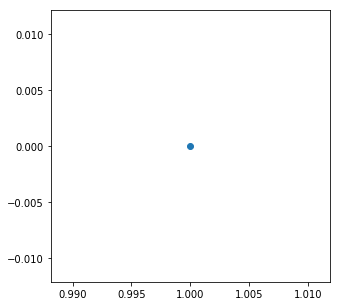

In [805]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
print(loss)
print(np.exp(loss))
ax.scatter([1],np.exp(loss))

In [806]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
grader.submit_VLB(loss)

Current answer for task Task 3 (VLB) is: -1213.9734643060176


### Bringing it all together

Now that we have E step, M step and VLB, we can implement training loop. We will start at random values of $\pi$, $\mu$ and $\Sigma$, train until $\mathcal{L}$ stops changing and return the resulting points. We also know that EM algorithm sometimes stops at local optima. To avoid this we should restart algorithm multiple times from different starting positions. Each training trial should stop either when maximum number of iterations is reached or when relative improvement is smaller than given tolerance ($|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal{L}_{i-1}}| \le \text{rtol}$).

Remember, that values of $\pi$ that you generate must be non-negative and sum up to 1. Also, $\Sigma$ matrices must be symmetric and positive semi-definite. If you don't know how to generate those matrices, you can use $\Sigma=I$ as initialization.

You will also sometimes get numerical errors because of component collapsing. The easiest way to deal with this problems is to simply restart the procedure.

<b>Task 4:</b> Implement training procedure

In [884]:
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    
    best_loss = []
    best_pi = []
    best_mu = []
    best_sigma = []
    
    
    for _ in range(restarts):
        try:
            ### YOUR CODE HERE
            # Random initialization of pi
            pi_ = np.random.randint(10, size=3)
            pi = pi_ / np.sum(pi_)
            
            # Random initialization of mu
            mu = 2 * np.random.random_sample((C,d))
            
            # Random initialization of sigma
            sigma = np.zeros((C,d,d))
            for i in range(C):
                sigma[i] = np.diag(np.ones(d))
                
            loss_ = []
            
            ### E and M steps
            for j in range(max_iter+1):
                gamma = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, gamma)
                loss = compute_vlb(X, pi, mu, sigma, gamma)
                loss_.append(loss)
                
                if(j!= 0):
                    if np.abs((loss - loss_[-2])/loss_[-2]) <= rtol:
                        break
                    else: 
                        if j == max_iter:
                            break
            best_loss.append(loss)
            best_pi.append(pi)
            best_mu.append(mu)
            best_sigma.append(sigma)
                        
                        
        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass
        
        #best_loss = best_loss_[np.argmax(best_loss_)] 
        #best_pi = best_pi_[np.argmax(best_pi_)] 
        #best_mu = best_mu_[np.argmax(best_mu_)]
        #best_sigma = best_sigma_[np.argmax(best_sigma_)]
        
        
    return best_loss[np.argmax(best_loss)], best_pi[np.argmax(best_loss)], best_mu[np.argmax(best_loss)], best_sigma[np.argmax(best_loss)]

In [885]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)
grader.submit_EM(best_loss)

C:\Users\20184732\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
C:\Users\20184732\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\20184732\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


Singular matrix: components collapsed
Current answer for task Task 4 (EM) is: -1063.8915753993692


If you implemented all the steps correctly, your algorithm should converge in about 20 iterations. Let's plot the clusters to see it. We will assign a cluster label as the most probable cluster index. This can be found using matrix $\gamma$ computed on last E-step. 


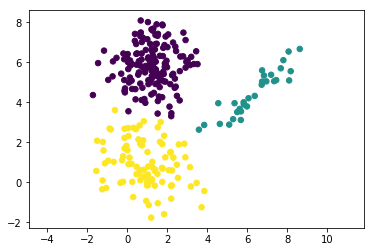

In [886]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30)
plt.axis('equal')
plt.show()

### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and your token into variables below. You can generate the token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [887]:
STUDENT_EMAIL = "slaglr@gmail.com"# EMAIL HERE
STUDENT_TOKEN = "NjwCgqE1mYyJEihK"# TOKEN HERE
grader.status()

You want to submit these numbers:
Task Task 1 (E-step): 0.533717874108129
Task Task 2 (M-step: mu): 2.8993918820503897
Task Task 2 (M-step: sigma): 5.977105216897535
Task Task 2 (M-step: pi): 0.5507624459218785
Task Task 3 (VLB): -1213.9734643060176
Task Task 4 (EM): -1063.8915753993692


If you want to submit these answers, run cell below

In [888]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
